In [16]:
%matplotlib inline

### Install Python Packages

In [17]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

### Get MNIST Dataset and DataLoader

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Flatten operation (assuming you want to flatten the tensor along the spatial dimensions)
flatten = transforms.Lambda(lambda x: x.view(-1))

# Combine the original transforms with the flatten operation
combined_transform = transforms.Compose([
    transform,
    flatten,
])

train_dataset = MNIST(root='./data', train=True, transform=combined_transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=combined_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

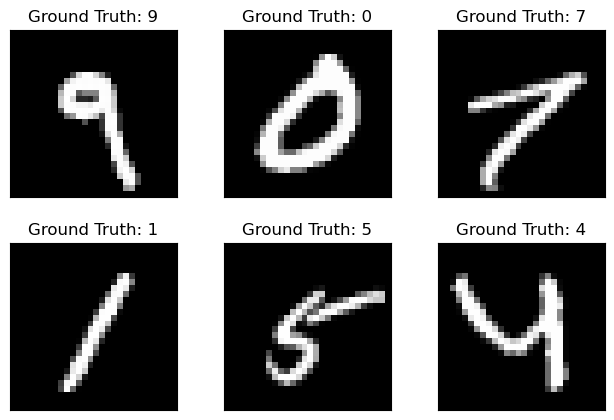

In [38]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Create MLP

In [52]:
class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Create Convolutional Nerual Net

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Select Model and Define HyperParameters

In [54]:
model = MLP(
    D_in = 28*28,
    H1 = 28*28,
    H2 = 128,
    D_out = 10,
)
# model = CNN()

print(model)

epochs = 10
learning_rate = 0.001
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Define Training Function

In [55]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()
    for batch, (data, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

### Define Training Function

In [56]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)\n')

### Train Model

In [57]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1 [0/60000] (0%)	Loss: 2.294573
Train Epoch: 1 [500/60000] (1%)	Loss: 2.311918
Train Epoch: 1 [1000/60000] (2%)	Loss: 2.325156
Train Epoch: 1 [1500/60000] (2%)	Loss: 2.293725
Train Epoch: 1 [2000/60000] (3%)	Loss: 2.301994
Train Epoch: 1 [2500/60000] (4%)	Loss: 2.273711
Train Epoch: 1 [3000/60000] (5%)	Loss: 2.282310
Train Epoch: 1 [3500/60000] (6%)	Loss: 2.295634
Train Epoch: 1 [4000/60000] (7%)	Loss: 2.262817
Train Epoch: 1 [4500/60000] (8%)	Loss: 2.257489
Train Epoch: 1 [5000/60000] (8%)	Loss: 2.292408
Train Epoch: 1 [5500/60000] (9%)	Loss: 2.276811
Train Epoch: 1 [6000/60000] (10%)	Loss: 2.250694
Train Epoch: 1 [6500/60000] (11%)	Loss: 2.244797
Train Epoch: 1 [7000/60000] (12%)	Loss: 2.256247
Train Epoch: 1 [7500/60000] (12%)	Loss: 2.242150
Train Epoch: 1 [8000/60000] (13%)	Loss: 2.244591
Train Epoch: 1 [8500/60000] (14%)	Loss: 2.283117
Train Epoch: 1 [9000/60000] (15%)	Loss: 2.248102
Train Epoch: 1 [9500/60000] (16%)	Loss: 2.196679
Train Epoch: 1 [10000/60000] (17%)	L

/Users/rchristopher/mambaforge/envs/nn/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test Set: Avg. Loss: -0.9410, Accuracy: 7253/10000 (73%)

Train Epoch: 2 [0/60000] (0%)	Loss: 1.521421
Train Epoch: 2 [500/60000] (1%)	Loss: 1.525588
Train Epoch: 2 [1000/60000] (2%)	Loss: 1.475113
Train Epoch: 2 [1500/60000] (2%)	Loss: 1.467217
Train Epoch: 2 [2000/60000] (3%)	Loss: 1.539158
Train Epoch: 2 [2500/60000] (4%)	Loss: 1.505834
Train Epoch: 2 [3000/60000] (5%)	Loss: 1.512227
Train Epoch: 2 [3500/60000] (6%)	Loss: 1.517666
Train Epoch: 2 [4000/60000] (7%)	Loss: 1.527595
Train Epoch: 2 [4500/60000] (8%)	Loss: 1.526213
Train Epoch: 2 [5000/60000] (8%)	Loss: 1.497923
Train Epoch: 2 [5500/60000] (9%)	Loss: 1.469103
Train Epoch: 2 [6000/60000] (10%)	Loss: 1.425964
Train Epoch: 2 [6500/60000] (11%)	Loss: 1.428883
Train Epoch: 2 [7000/60000] (12%)	Loss: 1.478667
Train Epoch: 2 [7500/60000] (12%)	Loss: 1.467176
Train Epoch: 2 [8000/60000] (13%)	Loss: 1.352159
Train Epoch: 2 [8500/60000] (14%)	Loss: 1.400630
Train Epoch: 2 [9000/60000] (15%)	Loss: 1.440988
Train Epoch: 2 [9500/60000

### Test Model

In [11]:
test(test_loader)

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_70039/3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test Set: Avg. Loss: 0.2361, Accuracy: 9314/10000 (93%)



### Plot Results

Text(0, 0.5, 'negative log likelihood loss')

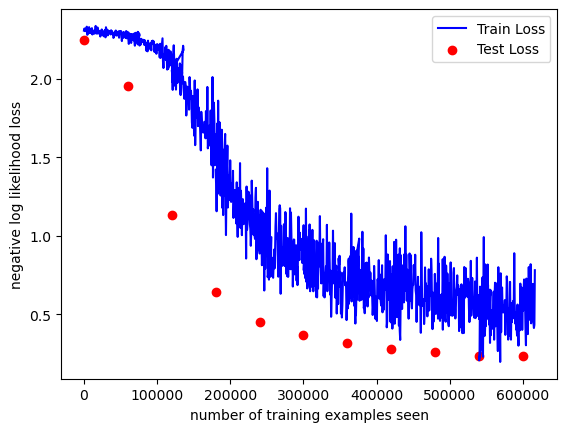

In [13]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.scatter(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_70039/3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


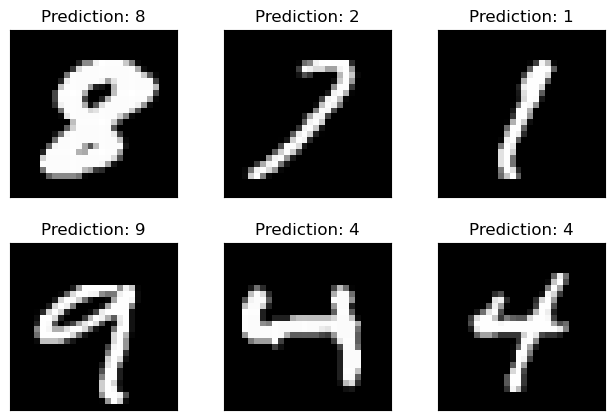

In [15]:
with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])